In [10]:
from mlxtend.classifier import StackingCVClassifier
import numpy as np
import pandas as pd
import sys, os, glob
import imp
import seaborn as sns
sys.path.append('./src/')
import common_utils,my_ensembler, feature_utils, defines, model_utils, my_bert
from sklearn.neighbors import KNeighborsClassifier
from sklearn_crfsuite import scorers, CRF
from sklearn.pipeline import Pipeline
import json
from operator import itemgetter
from sklearn_crfsuite.utils import flatten
from sklearn_crfsuite.metrics import sequence_accuracy_score
from sklearn.linear_model import LogisticRegression
import scipy
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
import classes
import pickle
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import re
from sklearn.metrics import PrecisionRecallDisplay
from sklearn import metrics


In [11]:
dir_name='duplicate'
final_pred_name='merged.crf.bert.ens.c.w.l'
final_feature_name='local.plot.tfidf.30'

In [12]:
all_pred_crf01=common_utils.load_db(dir_name,final_pred_name)
local_plot=common_utils.load_db(dir_name,final_feature_name)

Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/merged.crf.bert.ens.c.w.l.csv,  index False
Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/local.plot.tfidf.30.csv,  index False


# Plot precision-recall curve

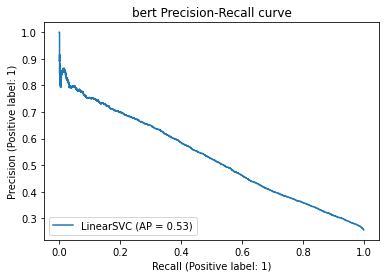

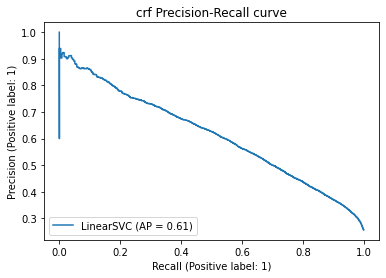

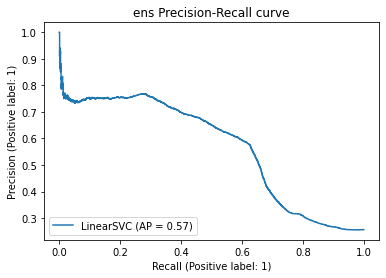

In [14]:
from sklearn.metrics import PrecisionRecallDisplay

for t in ['bert','crf','ens']:
    y_test=all_pred_crf01['{}_true'.format(t)].tolist()
    y_score=all_pred_crf01['{}_proba_1'.format(t)].tolist()

    display = PrecisionRecallDisplay.from_predictions(y_test, y_score, name="LinearSVC")
    _ = display.ax_.set_title("{} Precision-Recall curve".format(t))

# Plot ROC curve

Best Threshold=0.389610, G-Mean=0.677


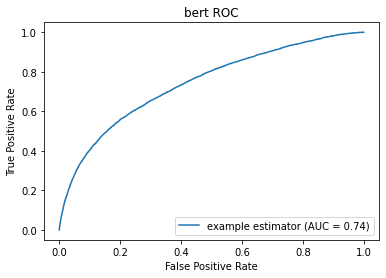

Best Threshold=0.203000, G-Mean=0.730


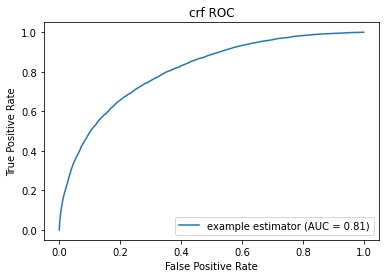

Best Threshold=0.159640, G-Mean=0.726


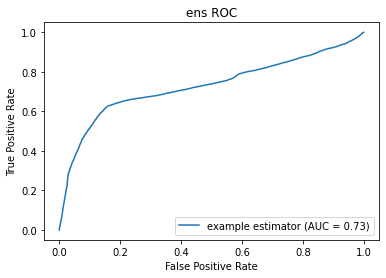

In [15]:
for t in ['bert','crf','ens']:
    y_test=all_pred_crf01['{}_true'.format(t)].tolist()
    y_score=all_pred_crf01['{}_proba_1'.format(t)].tolist()
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                       estimator_name='example estimator')
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
    display.plot()
    plt.title('{} ROC'.format(t))
    plt.show()

# Plot important features

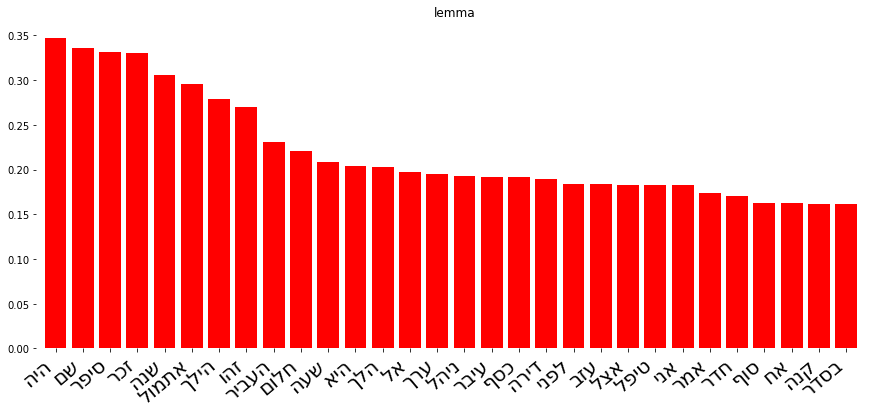

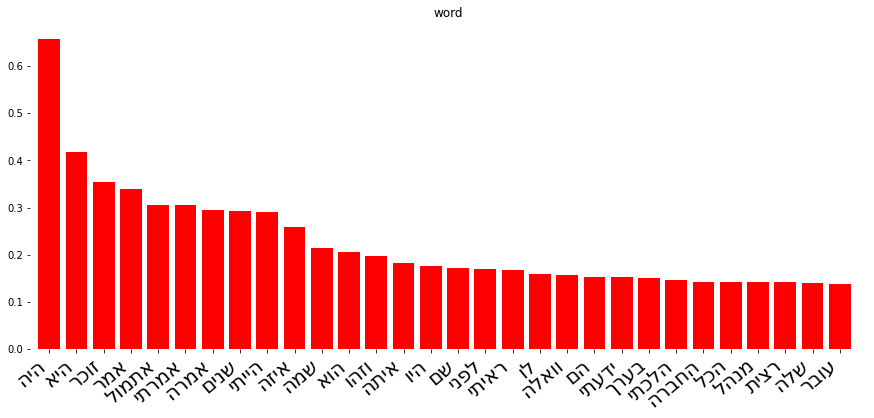

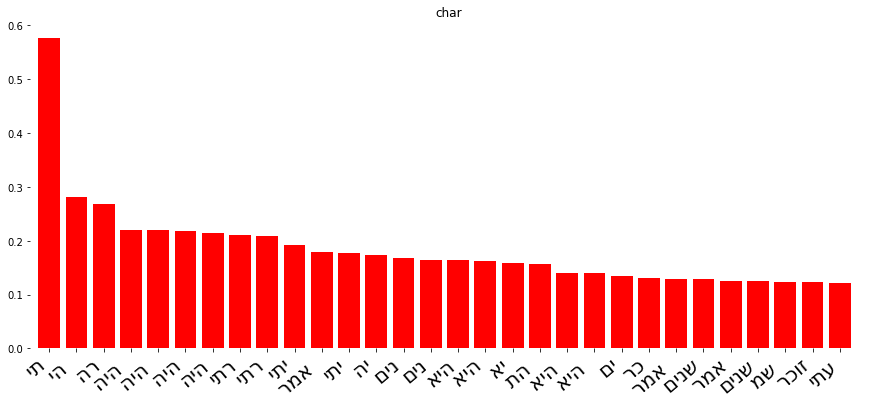

In [18]:
imp.reload(model_utils)
for tt in ['lemma','word','char']:
    plt.figure(figsize=(15, 6))
    ax=model_utils.plot_important_features(tt,local_plot['weight.{}.is_nar'.format(tt)].tolist(), local_plot['string.{}.is_nar'.format(tt)].tolist(), top_n=30, rotation=40)
    plt.show()